In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../..']

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import utils, evaluation_utils, visualization_utils
from sklearn.metrics import auc, precision_recall_curve
from statistics import mean
from datetime import datetime

In [3]:
# file_paths = {
#     "msl128vs30_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240824/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128vs30_s64/tl_tf_multi_sarscov2_variants_s.csv"),
#     "msl128vs30cls_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240825/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv"),
#     "msl256vs30_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240808/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256vs30_s64/tl_tf_multi_sarscov2_variants_s.csv"),
#     "msl256vs30cls_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240808/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv")
# }

file_paths = {
    "msl128vs30_ae_bn_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240829/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128ae_bn_vs30_s64/tl_tf_multi_sarscov2_variants_s.csv"),
    "msl128vs30cls_ae_bn_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240829/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128ae_bn_vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv"),
    #"msl256vs30_ae_bn_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240808/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256vs30_s64/tl_tf_multi_sarscov2_variants_s.csv"),
    "msl256vs30cls_ae_bn_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240829/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256ae_bn_vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv")
}

In [4]:
dfs = []
for k, v in file_paths.items():
    df = pd.read_csv(v)
    df["model"] = k
    df["id"] = df["id"].str.extract(r"\['(.+)'\]")
    index_seq_pred = df[df["id"] == "WIV04"]["Human"].values[0]
    df["Human_pred_diff"] = df["Human"] - index_seq_pred
    dfs.append(df)
df = pd.concat(dfs)
df

,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,id,y_true,model,Human_pred_diff
0,0.313971,0.014302,0.033688,0.014061,0.020911,0.576388,0.001933,0.024746,QWE88920.1,Human,msl128vs30_ae_bn_s64_UA,-0.070636
1,0.249402,0.015652,0.009969,0.013644,0.010999,0.680172,0.000490,0.019672,WRK13149.1,Human,msl128vs30_ae_bn_s64_UA,0.033149
2,0.264795,0.018356,0.030587,0.015605,0.020458,0.619114,0.001790,0.029296,QRF70806.1,Human,msl128vs30_ae_bn_s64_UA,-0.027909
3,0.212625,0.019896,0.026607,0.020095,0.016076,0.674555,0.002397,0.027749,UWM38596.1,Human,msl128vs30_ae_bn_s64_UA,0.027532
4,0.235204,0.016279,0.017468,0.010223,0.015454,0.679193,0.002945,0.023234,WGM84363.1,Human,msl128vs30_ae_bn_s64_UA,0.032170
5,0.023774,0.023813,0.016917,0.114932,0.035916,0.756219,0.000454,0.027976,QQX30509.1,Human,msl128vs30_ae_bn_s64_UA,0.109196
6,0.309256,0.013691,0.036948,0.017465,0.019580,0.582828,0.001138,0.019093,QUD52764.1,Human,msl128vs30_ae_bn_s64_UA,-0.064195
7,0.258656,0.011710,0.010743,0.007929,0.011741,0.677284,0.000698,0.021238,UFO69279.1,Human,msl128vs30_ae_bn_s64_UA,0.030261
8,0.287925,0.006555,0.006746,0.025093,0.018139,0.647023,0.000561,0.007957,WIV04,Human,msl128vs30_ae_bn_s64_UA,0.000000
9,0.260215,0.007941,0.010809,0.031886,0.017330,0.662651,0.000986,0.008183,QRX39425.1,Human,msl128vs30_ae_bn_s64_UA,0.015628


In [5]:
df

,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,id,y_true,model,Human_pred_diff
0,0.313971,0.014302,0.033688,0.014061,0.020911,0.576388,0.001933,0.024746,QWE88920.1,Human,msl128vs30_ae_bn_s64_UA,-0.070636
1,0.249402,0.015652,0.009969,0.013644,0.010999,0.680172,0.000490,0.019672,WRK13149.1,Human,msl128vs30_ae_bn_s64_UA,0.033149
2,0.264795,0.018356,0.030587,0.015605,0.020458,0.619114,0.001790,0.029296,QRF70806.1,Human,msl128vs30_ae_bn_s64_UA,-0.027909
3,0.212625,0.019896,0.026607,0.020095,0.016076,0.674555,0.002397,0.027749,UWM38596.1,Human,msl128vs30_ae_bn_s64_UA,0.027532
4,0.235204,0.016279,0.017468,0.010223,0.015454,0.679193,0.002945,0.023234,WGM84363.1,Human,msl128vs30_ae_bn_s64_UA,0.032170
5,0.023774,0.023813,0.016917,0.114932,0.035916,0.756219,0.000454,0.027976,QQX30509.1,Human,msl128vs30_ae_bn_s64_UA,0.109196
6,0.309256,0.013691,0.036948,0.017465,0.019580,0.582828,0.001138,0.019093,QUD52764.1,Human,msl128vs30_ae_bn_s64_UA,-0.064195
7,0.258656,0.011710,0.010743,0.007929,0.011741,0.677284,0.000698,0.021238,UFO69279.1,Human,msl128vs30_ae_bn_s64_UA,0.030261
8,0.287925,0.006555,0.006746,0.025093,0.018139,0.647023,0.000561,0.007957,WIV04,Human,msl128vs30_ae_bn_s64_UA,0.000000
9,0.260215,0.007941,0.010809,0.031886,0.017330,0.662651,0.000986,0.008183,QRX39425.1,Human,msl128vs30_ae_bn_s64_UA,0.015628


In [6]:
mapping_df = pd.read_csv(os.path.join(os.getcwd(), "..","..", "..", "..", "input/data/coronaviridae/20240313/wiv04/SARS_CoV_2_Variants_ViralZone.csv"))

In [7]:
mapping_df = mapping_df[~mapping_df["seq"].isna()]
mapping_df

,pango_lineage,who_name,tag,emergence_location,emergence_date,spike_mutations,seq,virus_host_name
0,BA.1,Omicron,Variant of Concern,South Africa,Dec-21,"A67V, H69-, V70-, T95I, G142D, V143-, Y144-, Y...",UFO69279.1,Homo sapiens
1,BA.2,Omicron,Variant of Concern,South Africa,Dec-21,"T19I, L24-, P25-, P26-, A27S, G142D, V213G, G3...",OM371884.1,Homo sapiens
2,BA.2.12.1,Omicron,Variant of Concern,North-America,Dec-21,"T19I, L24-, P25-, P26-, A27S, G142D, V213G, G3...",OM958567.1,Homo sapiens
3,BA.2.75,Omicron,Variant of Concern,India,Jun-22,"T19I, L24-, P25-, P26-, A27S, G142D, K147E, W1...",ON990685.1,Homo sapiens
4,JN.1,Omicron,Variant of Concern,Luxembourg,Jan-23,"A27S, A264D, A570V, D405N, D614G, D796Y, E484K...",WRK13149.1,Homo sapiens
5,BA.4,Omicron,Variant of Concern,South Africa,Jan-22,"T19I, L24-, P25-, P26-, A27S, H69-, V70-, V213...",UPP14409.1,Homo sapiens
6,BA.5,Omicron,Variant of Concern,South Africa,Jan-22,"T19I, L24-, P25-, P26-, A27S, H69-, V70-, V213...",UOZ45804.1,Homo sapiens
7,BQ.1.1,Omicron,Variant of Concern,Nigeria,Jul-22,"T19I, L24-, P25-, P26-, A27S, H69-, V70-, V213...",UWM38596.1,Homo sapiens
8,EG.5.1,Omicron,Variant of Concern,Indonesia/France/China,Jan-23,"A27S, D405N, D614G, D796Y, E484A, F456L, F486P...",WGM84363.1,Homo sapiens
9,XBB.1.5,Omicron,Variant of Concern,USA,Nov-22,"A27S, A475V, D405N, D614G, D796Y, E484A, F456L...",UZG29433.1,Homo sapiens


In [8]:
mapping_df["emergence_date"] = mapping_df["emergence_date"].apply(lambda x: datetime.strftime(datetime.strptime(x, '%b-%y'), '%m/%Y'))
mapping_df["emergence_date"] = pd.to_datetime(mapping_df["emergence_date"])

In [9]:
df = df.merge(mapping_df[["seq", "pango_lineage", "emergence_date"]], how="left", left_on="id", right_on="seq")

In [10]:
order = list(df.sort_values(by="emergence_date")["pango_lineage"].unique())

In [11]:
order

['WIV04',
 'B.1.1.28.1',
 'B.1.351',
 'B.1.1.7',
 'B.1.427, B.1.429',
 'B.1.1.28.2',
 'B.1.526',
 'B.1.617.2',
 'B.1.525',
 'B.1.1.1.C37',
 'B.1.617.1',
 'BA.1',
 'BA.5',
 'BA.4',
 'BQ.1.1',
 'XBB.1.5',
 'EG.5.1',
 'JN.1']

In [12]:
df[df["pango_lineage"] == "B.1.1.28.1"]

,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,id,y_true,model,Human_pred_diff,seq,pango_lineage,emergence_date
9,0.260215,0.007941,0.010809,0.031886,0.017330,0.662651,0.000986,0.008183,QRX39425.1,Human,msl128vs30_ae_bn_s64_UA,0.015628,QRX39425.1,B.1.1.28.1,2020-07-01
26,0.159857,0.006361,0.007946,0.021393,0.020053,0.774977,0.001336,0.008077,QRX39425.1,Human,msl128vs30cls_ae_bn_s64_UA,-0.015306,QRX39425.1,B.1.1.28.1,2020-07-01
37,0.176900,0.004418,0.019973,0.006542,0.017626,0.769994,0.000195,0.004351,QRX39425.1,Human,msl256vs30cls_ae_bn_s64_UA,-0.005159,QRX39425.1,B.1.1.28.1,2020-07-01


In [13]:
df

,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,id,y_true,model,Human_pred_diff,seq,pango_lineage,emergence_date
0,0.313971,0.014302,0.033688,0.014061,0.020911,0.576388,0.001933,0.024746,QWE88920.1,Human,msl128vs30_ae_bn_s64_UA,-0.070636,QWE88920.1,B.1.1.7,2020-09-01
1,0.249402,0.015652,0.009969,0.013644,0.010999,0.680172,0.000490,0.019672,WRK13149.1,Human,msl128vs30_ae_bn_s64_UA,0.033149,WRK13149.1,JN.1,2023-01-01
2,0.264795,0.018356,0.030587,0.015605,0.020458,0.619114,0.001790,0.029296,QRF70806.1,Human,msl128vs30_ae_bn_s64_UA,-0.027909,QRF70806.1,B.1.525,2020-12-01
3,0.212625,0.019896,0.026607,0.020095,0.016076,0.674555,0.002397,0.027749,UWM38596.1,Human,msl128vs30_ae_bn_s64_UA,0.027532,UWM38596.1,BQ.1.1,2022-07-01
4,0.235204,0.016279,0.017468,0.010223,0.015454,0.679193,0.002945,0.023234,WGM84363.1,Human,msl128vs30_ae_bn_s64_UA,0.032170,WGM84363.1,EG.5.1,2023-01-01
5,0.023774,0.023813,0.016917,0.114932,0.035916,0.756219,0.000454,0.027976,QQX30509.1,Human,msl128vs30_ae_bn_s64_UA,0.109196,QQX30509.1,B.1.1.28.2,2020-10-01
6,0.309256,0.013691,0.036948,0.017465,0.019580,0.582828,0.001138,0.019093,QUD52764.1,Human,msl128vs30_ae_bn_s64_UA,-0.064195,QUD52764.1,B.1.617.2,2020-12-01
7,0.258656,0.011710,0.010743,0.007929,0.011741,0.677284,0.000698,0.021238,UFO69279.1,Human,msl128vs30_ae_bn_s64_UA,0.030261,UFO69279.1,BA.1,2021-12-01
8,0.287925,0.006555,0.006746,0.025093,0.018139,0.647023,0.000561,0.007957,WIV04,Human,msl128vs30_ae_bn_s64_UA,0.000000,WIV04,WIV04,2019-12-01
9,0.260215,0.007941,0.010809,0.031886,0.017330,0.662651,0.000986,0.008183,QRX39425.1,Human,msl128vs30_ae_bn_s64_UA,0.015628,QRX39425.1,B.1.1.28.1,2020-07-01


/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret input 'pango_lineage'

<Figure size 432x288 with 0 Axes>

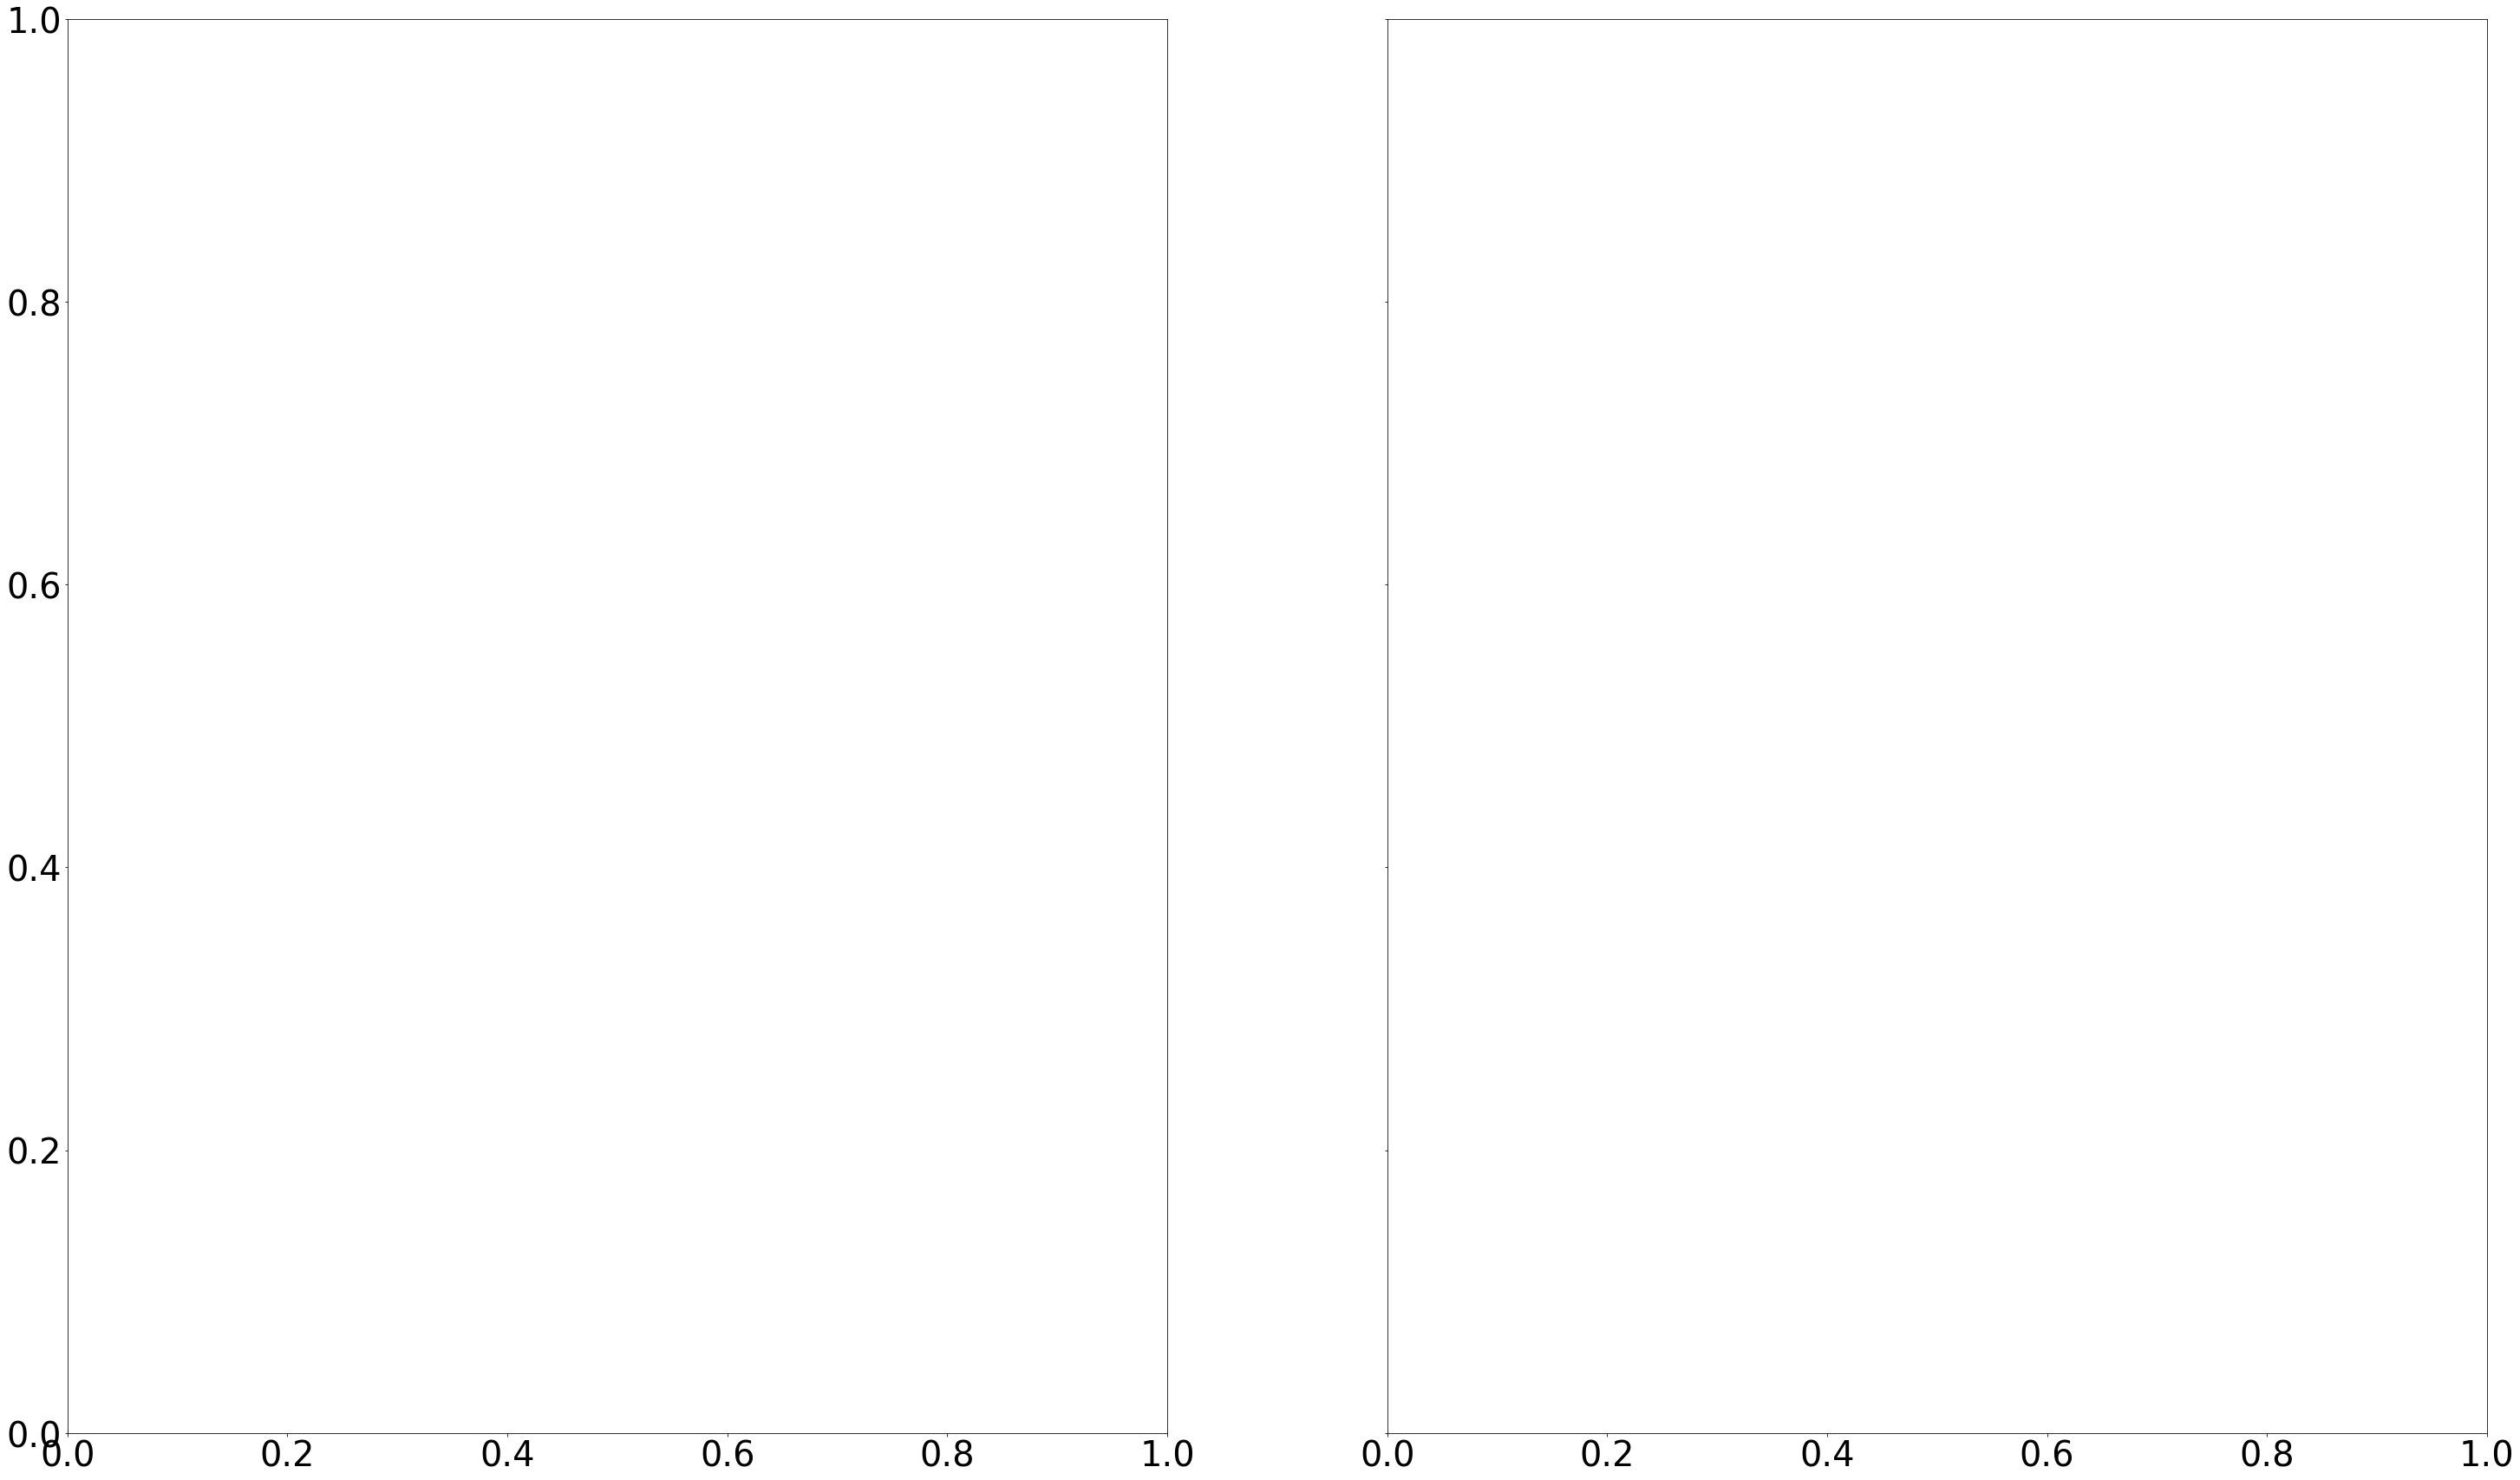

In [14]:
plt.clf()
plt.rcParams['xtick.labelsize'] = 40
plt.rcParams['ytick.labelsize'] = 40
plt.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 2, figsize=(50, 30), sharex=False, sharey=True)

colors = sns.color_palette('tab10')
models = list(df["model"].unique())

color_palette_dict = {k: v for k, v in zip(models, colors)}

sns.barplot(df,  x="Human", y="pango_lineage", hue="model", ax=axs[0], order=order)
               # boxprops={"facecolor": (.3, .5, .7, .5)})
sns.move_legend(axs[0], "lower right", bbox_to_anchor=(.5, -.2))

for model, color in zip(models, colors):
    axs[0].axvline(df[(df["model"] == model) & (df["id"] == "WIV04")]["Human"].values[0], color=color, linestyle="--")

sns.heatmap(df.pivot(index="pango_lineage", columns="model", values="Human_pred_diff"), ax=axs[1], linewidth=.1, center=0, cmap="vlag")
axs[1].set_ylabel("")
plt.show()
    
    


In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(50, 30), sharex=False, sharey=True)
sns.heatmap(df.pivot(index="pango_lineage", columns="model", values="Human_pred_diff"), ax=axs, linewidth=.1, center=0, cmap="vlag")
plt.show()

In [ ]:
def get_annotation_df(heatmap_df):
    annot_df = pd.DataFrame(0, index=heatmap_df.index, columns=heatmap_df.columns)
    annot_idx = heatmap_df.idxmax(axis=1).reset_index()
    for item in annot_idx.values:
        annot_df.loc[item[0], item[1]] = "{:,.2f}".format(heatmap_df.loc[item[0], item[1]])
        annot_df.loc[item[0], "Human"] = "{:,.2f}".format(heatmap_df.loc[item[0], "Human"])
    annot_df = annot_df.astype(str)
    annot_df[annot_df == "0"] = ""
    
    return annot_df
 
fig, axs = plt.subplots(1, 3, figsize=(60, 30), sharex=False, sharey=True)

cbar_ax = fig.add_axes([.91, .3, .01, .5])
for i, model in enumerate(models):
    heatmap_df = df[df["model"] == model][["Cat", "Cattle", "Chicken", "Dromedary camel", "Gray wolf", "Human", "Pig", "Yak", "pango_lineage"]].set_index("pango_lineage").reindex(index=order)
    get_annotation_df(heatmap_df)
    sns.heatmap(heatmap_df, ax=axs[i], linewidth=.1,
                annot=get_annotation_df(heatmap_df), fmt="",
                vmin=0, vmax=1,
                cbar=i == 0, 
                cbar_ax=None if i != 0 else cbar_ax)
    axs[i].set_title(model)
    axs[i].set(xlabel="", ylabel="")

plt.show()